In [166]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [167]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False, low_memory=False)

In [168]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The...,29.883056,-97.941111,1949-10-10
1,lackland afb,tx,NaN,light,120.000000,1949 Lackland AFB&#44 TX. Lights racing across the sky &amp; making 90 degree turns on a dime.,29.384210,-98.581082,1949-10-10
2,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 England,53.200000,-2.916667,1955-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a ...,21.418056,-157.803611,1960-10-10


In [169]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

88673
[[-97.9411111  29.8830556]
 [-98.581082   29.38421  ]
 [ -2.916667   53.2      ]
 ...
 [-97.4777778  35.6527778]
 [-82.6958333  34.3769444]
 [-80.1436111  26.1219444]]


### Analise por estados

In [170]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

states = list(df['state'])
pesos_s = [states.count(s) for s in states]

In [171]:
scaler = MinMaxScaler()

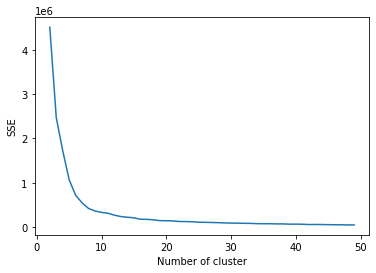

In [172]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos_s)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Visto que o range para o Elbow Criteria foi grande, o número adequado de clusters está entre 5 e 20
#### A soma dos erros quadráticos não apresenta decaimento significante a partir desses valores, logo o gasto computacional para k_clusters maiores não se torna viável

### Para definir o melhor valor nesse range, foi utilizado o Coeficiente de Silhouette
#### quanto maior o coeficiente, menor a distância intracluster e maior a distância intercluster

In [173]:
# aplica o coeficiente de silhouette

for k in range(5, 20):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos_s)
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=5, o coeficiente de  Silhouette 0.5312048697121609
Para n_clusters=6, o coeficiente de  Silhouette 0.5374589390876062
Para n_clusters=7, o coeficiente de  Silhouette 0.4987885976923663
Para n_clusters=8, o coeficiente de  Silhouette 0.5362444536699965
Para n_clusters=9, o coeficiente de  Silhouette 0.5335383391312584
Para n_clusters=10, o coeficiente de  Silhouette 0.5003200301893481
Para n_clusters=11, o coeficiente de  Silhouette 0.47692061606598524
Para n_clusters=12, o coeficiente de  Silhouette 0.4620942585723777
Para n_clusters=13, o coeficiente de  Silhouette 0.4372379189059276
Para n_clusters=14, o coeficiente de  Silhouette 0.4795034438299888
Para n_clusters=15, o coeficiente de  Silhouette 0.44079064769282345
Para n_clusters=16, o coeficiente de  Silhouette 0.505151270430281
Para n_clusters=17, o coeficiente de  Silhouette 0.4887000219005324
Para n_clusters=18, o coeficiente de  Silhouette 0.44108517248029694
Para n_clusters=19, o coeficiente de  Silhouette 0.

### De acordo com o Score Silhouette o número adequado de clusters é em torno de 8

In [174]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=8, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos_s)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.22167546, 0.72476095],
       [0.21987323, 0.72155423],
       [0.4892746 , 0.87464866],
       ...,
       [0.22298025, 0.7618503 ],
       [0.26460781, 0.7536489 ],
       [0.27179515, 0.70058349]])

In [175]:
centers = kmeans.cluster_centers_
centers

array([[0.26870241, 0.7950912 ],
       [0.50633837, 0.85926837],
       [0.91172723, 0.31983763],
       [0.16404041, 0.76159318],
       [0.48474531, 0.49893768],
       [0.1548866 , 0.83476387],
       [0.75302649, 0.66917921],
       [0.25020943, 0.71794883]])

In [176]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

88673


array([7., 7., 1., ..., 7., 7., 7.])

Text(0, 0.5, 'Longitude')

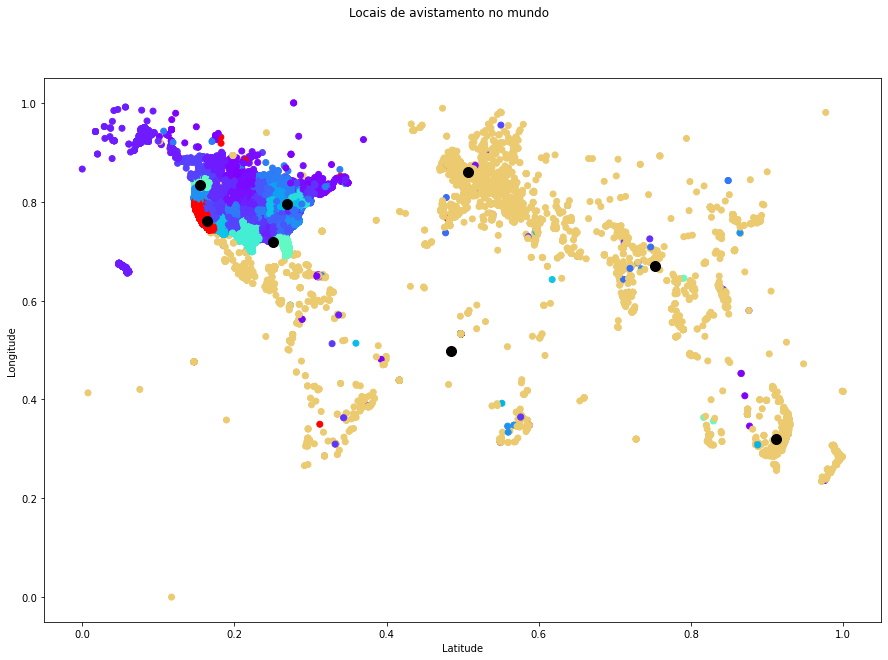

In [177]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos_s, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [178]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [179]:
centers_notscaled = scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers_notscaled)

for index, row in df_centers.iterrows():
    df_centers.at[index, 'location'] = str(row[1]) + ', ' + str(row[0])

df_centers.drop(0, axis=1, inplace=True)
df_centers.drop(1, axis=1, inplace=True)

df_centers

,location
0,"40.82382360791828, -81.24184188698418"
1,"50.80740018438337, 3.1426774594748554"
2,"-33.107929499804385, 147.09624463472986"
3,"35.61277926381145, -118.40731210691393"
4,"-5.246633538442216, -4.52501732326462"
5,"46.99541359052153, -121.6578312215139"
6,"21.236607985852324, 90.7416168860791"
7,"28.823343713162078, -87.80869963570584"


In [181]:
df_centers['address'] = df_centers['location'].apply(lambda loc: reverse(loc) if loc else None)

In [182]:
pd.set_option("max_colwidth", 120)
df_centers

,location,address
0,"40.82382360791828, -81.24184188698418","(Marion Avenue Southeast, Louisville, Stark County, Ohio, 44641, United States, (40.82719, -81.242431))"
1,"50.80740018438337, 3.1426774594748554","(94, Processiestraat, Menen, Kortrijk, West-Vlaanderen, Vlaanderen, 8930, België / Belgique / Belgien, (50.8076124, ..."
2,"-33.107929499804385, 147.09624463472986","(Condobolin, Lachlan Shire Council, New South Wales, 2877, Australia, (-33.0880805, 147.1479606))"
3,"35.61277926381145, -118.40731210691393","(2483, Shadow Mountain Drive, Squirrel Mountain Valley, Kern County, California, 93240, United States, (35.612831599..."
4,"-5.246633538442216, -4.52501732326462",None
5,"46.99541359052153, -121.6578312215139","(Lake Eleanor Trail, Pierce County, Washington, United States, (46.991329, -121.6543889))"
6,"21.236607985852324, 90.7416168860791",None
7,"28.823343713162078, -87.80869963570584",None


In [204]:
df_s = df['state'].value_counts().rename_axis('country').reset_index(name='count')
df_s.head(15)

,country,count
0,ca,10448
1,wa,4650
2,fl,4596
3,tx,4041
4,ny,3506
5,az,2937
6,il,2874
7,pa,2780
8,oh,2638
9,mi,2253


### Analise por país

In [183]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

countrys = list(df['country'])
pesos_c = [countrys.count(c) for c in countrys]

In [184]:
scaler = MinMaxScaler()

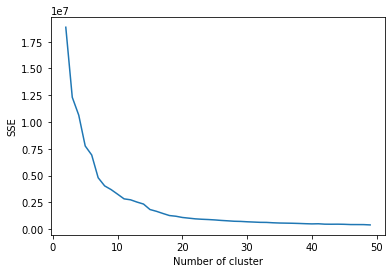

In [185]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos_c)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Visto que o range para o Elbow Criteria foi grande, o número adequado de clusters está entre 5 e 25
#### A soma dos erros quadráticos não apresenta decaimento significante a partir desses valores, logo o gasto computacional para k_clusters maiores não se torna viável

### Para definir o melhor valor nesse range, foi utilizado o Coeficiente de Silhouette
#### quanto maior o coeficiente, menor a distância intracluster e maior a distância intercluster

In [186]:
# aplica o coeficiente de silhouette

for k in range(5, 25):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos_c)
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=5, o coeficiente de  Silhouette 0.46598316840529724
Para n_clusters=6, o coeficiente de  Silhouette 0.4897882658227698
Para n_clusters=7, o coeficiente de  Silhouette 0.5258168934605912
Para n_clusters=8, o coeficiente de  Silhouette 0.5313451159941194
Para n_clusters=9, o coeficiente de  Silhouette 0.49102312490102323
Para n_clusters=10, o coeficiente de  Silhouette 0.4595092735305331
Para n_clusters=11, o coeficiente de  Silhouette 0.4810090414515804
Para n_clusters=12, o coeficiente de  Silhouette 0.5036531951849171
Para n_clusters=13, o coeficiente de  Silhouette 0.5085155991356703
Para n_clusters=14, o coeficiente de  Silhouette 0.509036771337527
Para n_clusters=15, o coeficiente de  Silhouette 0.49886548703997974
Para n_clusters=16, o coeficiente de  Silhouette 0.47910414097105325
Para n_clusters=17, o coeficiente de  Silhouette 0.5192344391342331
Para n_clusters=18, o coeficiente de  Silhouette 0.5173712567867976
Para n_clusters=19, o coeficiente de  Silhouette 0

In [192]:
# aplica o coeficiente de silhouette
# pra mim na vdd ta entre 15 e 25 aí rodei tudo aqui embaixo pra confirmar mas deu 8 mesmo. deixei aqui pra ti analisar
# pq ainda estou desconfiada rs

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos_c)
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=2, o coeficiente de  Silhouette 0.32163981936642
Para n_clusters=3, o coeficiente de  Silhouette 0.4516715032745854
Para n_clusters=4, o coeficiente de  Silhouette 0.3827590405592425
Para n_clusters=5, o coeficiente de  Silhouette 0.5319820538588717
Para n_clusters=6, o coeficiente de  Silhouette 0.4897882658227698
Para n_clusters=7, o coeficiente de  Silhouette 0.5258700396145566
Para n_clusters=8, o coeficiente de  Silhouette 0.5331172866779205
Para n_clusters=9, o coeficiente de  Silhouette 0.4903310925691176
Para n_clusters=10, o coeficiente de  Silhouette 0.4620663927745964
Para n_clusters=11, o coeficiente de  Silhouette 0.49592011583260964
Para n_clusters=12, o coeficiente de  Silhouette 0.4930959779880314
Para n_clusters=13, o coeficiente de  Silhouette 0.49743876541659005
Para n_clusters=14, o coeficiente de  Silhouette 0.4762036209631907
Para n_clusters=15, o coeficiente de  Silhouette 0.5104880911600669
Para n_clusters=16, o coeficiente de  Silhouette 0.50119

### De acordo com o Coeficiente de Silhouette o número adequado de clusters é em torno de 8

In [193]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=8, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos_c)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.22167546, 0.72476095],
       [0.21987323, 0.72155423],
       [0.4892746 , 0.87464866],
       ...,
       [0.22298025, 0.7618503 ],
       [0.26460781, 0.7536489 ],
       [0.27179515, 0.70058349]])

In [194]:
centers = kmeans.cluster_centers_
centers

array([[0.25174231, 0.73498279],
       [0.48624662, 0.50484434],
       [0.28460997, 0.79463857],
       [0.16971533, 0.76141482],
       [0.52672614, 0.84103309],
       [0.81945978, 0.56303158],
       [0.15443166, 0.83536741],
       [0.24593237, 0.79682632]])

In [195]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

88673


array([0., 0., 4., ..., 0., 0., 0.])

Text(0, 0.5, 'Longitude')

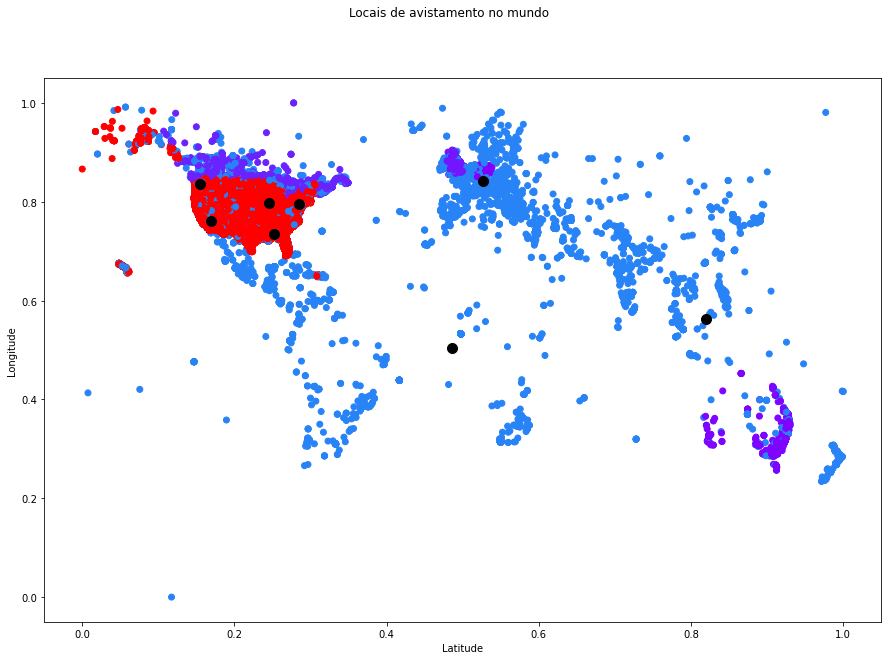

In [196]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos_c, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [197]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [198]:
centers_notscaled = scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers_notscaled)

for index, row in df_centers.iterrows():
    df_centers.at[index, 'location'] = str(row[1]) + ', ' + str(row[0])

df_centers.drop(0, axis=1, inplace=True)
df_centers.drop(1, axis=1, inplace=True)

df_centers

,location
0,"31.473193429377172, -87.26437352769351"
1,"-4.327776928188429, -3.9919026318325552"
2,"40.7534100728939, -75.59306673630557"
3,"35.5850323933187, -116.39215118648978"
4,"47.97066952806195, 10.382372490627283"
5,"4.723990172361304, 114.3320774966908"
6,"47.089301112431635, -121.81937876018608"
7,"41.09374316275741, -89.32748333520956"


In [199]:
df_centers['address'] = df_centers['location'].apply(lambda loc: reverse(loc) if loc else None)

In [200]:
pd.set_option("max_colwidth", 120)
df_centers

,location,address
0,"31.473193429377172, -87.26437352769351","(Wait Road, Monroe County, Alabama, 36460, United States, (31.473373, -87.263062))"
1,"-4.327776928188429, -3.9919026318325552",None
2,"40.7534100728939, -75.59306673630557","(NAPA Auto Parts, Lehigh Gap Street, Walnutport, Northampton County, Pennsylvania, 18088, United States, (40.7530666..."
3,"35.5850323933187, -116.39215118648978","(San Bernardino County, California, United States, (34.8253019, -116.0833144))"
4,"47.97066952806195, 10.382372490627283","(Altisried, Markt Rettenbach, Landkreis Unterallgäu, Bayern, 87733, Deutschland, (47.971506, 10.3794295))"
5,"4.723990172361304, 114.3320774966908",None
6,"47.089301112431635, -121.81937876018608","(Pierce County, Washington, United States, (47.0022547, -122.2117983))"
7,"41.09374316275741, -89.32748333520956","(Marshall County, Illinois, United States, (41.096861599924175, -89.32682386243215))"


In [201]:
df_c = df['country'].value_counts().rename_axis('country').reset_index(name='count')
df_c.head(15)

,country,count
0,us,70290
1,ca,3266
2,gb,2050
3,au,593
4,de,112
